In [2]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, format='%(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
import sys, os

# Checkpoint file to resume pre-precessing if interrupted.
# It contains the list of files, that have already been processed.
CHECKPOINT_FILE_NAME = 'checkpoint.txt'

def read_file(file_name):
    """Reads file contents into a string array."""
    with open(file_name) as f:
        return [line.rstrip() for line in f]

def mark_file_as_processed(out_dir, file_name):
    """Updates checkpoint file in the output directory."""
    checkpoint_file = os.path.join(out_dir, CHECKPOINT_FILE_NAME)
    # Creates file if doesn't exists.
    with open(checkpoint_file,'a+') as f:
        f.write(file_name)
        f.write('\n')
        f.close()

def get_files_to_process(in_dir, out_dir=None):
    """Gets list of files for processing. If 'out_dir' is specified, filters out already processed file by looking at checkpoint file."""
    if  out_dir:
        checkpoint_file_name = os.path.join(out_dir, CHECKPOINT_FILE_NAME)
        processed_files = []
        if os.path.exists(checkpoint_file_name):
            processed_files = set(read_file(checkpoint_file_name))
    else:
        processed_files = []

    result = []
    for root, _, filenames in os.walk(in_dir):
        for file_name in filenames: 
            rel_file_name = os.path.relpath(os.path.join(root, file_name), in_dir)
            if file_name == '.DS_Store' \
                or file_name == CHECKPOINT_FILE_NAME \
                or rel_file_name in processed_files:
                logger.debug('Skipping file: {}'.format(rel_file_name))
                continue
            result.append(rel_file_name)
    return sorted(result)

In [4]:
import sys, os
import cv2
import numpy as np
import pytesseract
from pdf2image import convert_from_path

def pdf_to_images(in_dir, out_dir):
    """Converts each pdf file in in_dir into JPEG image, with one image per page, and writes them to out_dir."""
    pdfs = get_files_to_process(in_dir, out_dir)
    for pdf in pdfs:
        in_file = os.path.join(in_dir, pdf)
        logger.info('processing: {}'.format(in_file))
        pages = convert_from_path(in_file, 500)
        page_count = 1

        for page in pages:
            out_file_name = os.path.join(out_dir, '{}_{:04d}.jpg'.format(pdf, page_count))
            os.makedirs((os.path.dirname(out_file_name)), exist_ok=True)
            logger.debug('writing out file: {}'.format(out_file_name))
            page.save(out_file_name, 'JPEG')
            page_count = page_count + 1
        mark_file_as_processed(out_dir, pdf)

def crop_images(in_dir, out_dir, h_slice=2, v_slice=2):
    """Make slice of .png files into 4 equal parts."""
    images = get_files_to_process(in_dir, out_dir)

    for image in images:
        in_file = os.path.join(in_dir, image)
        logger.info('processing: {}'.format(in_file))
        img = cv2.imread(in_file)
        h, w, _ = img.shape

        out_file_prefix = os.path.splitext(image)[0]
        for h_idx in range(h_slice):
            for v_idx in range(v_slice):
                x1 = int(w / v_slice * v_idx)
                y1 = int(h / h_slice * h_idx)
                x2 = int(x1 + (w / v_slice))
                y2 = int(y1 + (h / h_slice))
                out_file_name = os.path.join(out_dir, \
                    '{}_{}x{}_{}{}.png'.format(out_file_prefix, h_slice, v_slice, h_idx, v_idx))
                os.makedirs((os.path.dirname(out_file_name)), exist_ok=True)
                logger.debug('writing out file: {}'.format(out_file_name))
                cv2.imwrite(out_file_name, img[y1:y2, x1:x2])
        mark_file_as_processed(out_dir, image)

def images_to_text(in_dir, out_dir):
    """Extracts text information from a given image"""
    images = get_files_to_process(in_dir, out_dir)

    for image in images:
        in_file = os.path.join(in_dir, image)
        logger.info('processing: {}'.format(in_file))
        text = pytesseract.image_to_string(in_file)

        out_file_name = os.path.join(out_dir, os.path.splitext(image)[0] + '.txt')
        os.makedirs((os.path.dirname(out_file_name)), exist_ok=True)
        text_file = open(out_file_name, 'w')
        text_file.write(text)
        text_file.close()       
        mark_file_as_processed(out_dir, image)

def word_count(in_dir, out_dir):
    """Counts the number of words from a given text file."""
    text_files = get_files_to_process(in_dir, out_dir)

    for text_file in text_files:
        in_file = os.path.join(in_dir, text_file)
        logger.info('processing: {}'.format(in_file))
        with open(in_file) as file:
            word_count = len(file.read().split())

        out_file_name = os.path.join(out_dir, text_file)
        os.makedirs((os.path.dirname(out_file_name)), exist_ok=True)
        out_file = open(out_file_name, 'w')
        out_file.write(str(word_count))
        out_file.close()       
        mark_file_as_processed(out_dir, text_file)        

def get_header_text(file):
    '''Finds header in a table of an input image and extracts the text from that header.'''
    table_image_contour = cv2.imread(file, 0)
    table_image = cv2.imread(file)
    ret, thresh_value = cv2.threshold(table_image_contour, 180, 255, cv2.THRESH_BINARY_INV)
    img_h = thresh_value.shape[0]
    img_w = thresh_value.shape[1]
    kernel = np.ones((5,5),np.uint8)
    dilated_value = cv2.dilate(thresh_value,kernel,iterations = 1)
    _, contours, hierarchy = cv2.findContours(dilated_value, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        t_x, t_y, t_w, t_h = cv2.boundingRect(max(contours, key=lambda cnt: cv2.contourArea(cnt)))
        potential_headers = []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if (w > 0.9*t_w and h < 0.3*t_h and abs(t_y - y) < 50):
                potential_headers.append(cnt)
        # Return the one with minumum area
        if len(potential_headers) > 0:
            header_cnt = min(potential_headers, key=lambda cnt: cv2.contourArea(cnt))
            x, y, w, h = cv2.boundingRect(header_cnt)
            header_img = table_image[y:y+h, x:x+w]
            return pytesseract.image_to_string(header_img)
    return ''

def images_to_header_text(in_dir, out_dir):
    '''processes all files in a given directory. uses get_header_text() function to process individual file.'''
    images = get_files_to_process(in_dir, out_dir)

    for image in images:
        in_file = os.path.join(in_dir, image)
        logger.info('processing: {}'.format(in_file))
        header_text = get_header_text(in_file)

        out_file_name = os.path.join(out_dir, os.path.splitext(image)[0] + '.txt')
        os.makedirs((os.path.dirname(out_file_name)), exist_ok=True)
        out_file = open(out_file_name, 'w')
        out_file.write(header_text)
        out_file.close()
        mark_file_as_processed(out_dir, image)

def get_contour_info(img_file_path):
    '''Computes contours for cells on page and average color. '''
    img = cv2.imread(img_file_path)
    if len(img.shape) != 2:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    ret, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY_INV)
    # Calculate average color after converting the image into binary color (black and white), and before we make further changes.
    avg_color_per_row = np.average(thresh, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)

    # Make the horizontal and vertical lines bolder
    thresh = cv2.dilate(thresh, np.ones((5,1),np.uint8))
    thresh = cv2.dilate(thresh, np.ones((1,5),np.uint8))

    # Find all contours as list. See (for param description): https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html#findcontours
    _, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Count all contours which enclose an area above certain threshold to remove noise.
    contour_count = 0
    img_h = thresh.shape[0]
    img_w = thresh.shape[1]
    min_area = min(10000, img_h * img_w//1000) # assuming max 1000 cells
    filtered_contours = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w >= 0.7*img_w or cv2.contourArea(cnt) >= min_area:
            contour_count = contour_count + 1
            filtered_contours.append(cnt)
    return filtered_contours, avg_color

def contour_infos(in_dir, out_dir, display_image_with_contours = False):
    '''Save contour infos into a directory.'''
    images = get_files_to_process(in_dir, out_dir)

    for image in images:
        in_file = os.path.join(in_dir, image)
        logger.info('processing: {}'.format(in_file))
        contours, avg_color = get_contour_info(in_file)

        out_file_name = os.path.join(out_dir, os.path.splitext(image)[0] + '.txt')
        os.makedirs((os.path.dirname(out_file_name)), exist_ok=True)
        out_file = open(out_file_name, 'w')
        out_file.write(str(len(contours)) + ", " + str(avg_color))
        out_file.close()
        mark_file_as_processed(out_dir, image)

        if display_image_with_contours:
            # cv2.imshow('dilated', thresh)
            image_with_contour = cv2.imread(in_file)
            for cnt in contours:
                x,y,w,h = cv2.boundingRect(cnt)
                cv2.rectangle(image_with_contour, (x,y), (x+w,y+h), (255,0,0), 2)
            cv2.imshow('contour', image_with_contour)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

def pre_process():    
    pdf_to_images('./data/pdfs/', './data/images/')
    logger.debug('Done processing: pdf_to_images')

    crop_images('./data/images', './data/images_cropped')
    logger.debug('Done processing: crop_images')

    images_to_text('./data/images', './data/text_images')
    logger.debug('Done processing: images_to_text')

    images_to_text('./data/images_cropped', './data/text_images_cropped')
    logger.debug('Done processing: images_to_text(cropped)')

    images_to_header_text('./data/images', './data/header_text_images')
    logger.debug('Done processing: images_to_header_text')

    images_to_header_text('./data/images_cropped', './data/header_text_images_cropped')
    logger.debug('Done processing: images_to_header_text(cropped)')

    word_count('./data/text_images', './data/word_count')
    logger.debug('Done processing: word_count')

    word_count('./data/text_images_cropped', './data/word_count_cropped')
    logger.debug('Done processing: word_count(cropped)')

    contour_infos('./data/images', './data/features')
    logger.debug('Done processing: contour_infos')

    contour_infos('./data/images_cropped', './data/features_cropped')
    logger.debug('Done processing: contour_infos(cropped)')
pre_process()
logger.info('Done pre-processing.')

Done pre-processing.


In [5]:
import os
import pickle
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

def get_documents(in_dir, out_file_name, nth = 1, force_create = False):
    if os.path.exists(out_file_name) and not force_create:
        logger.debug('documents already exists: {}'.format(out_file_name))
        return pickle.load(open(out_file_name, "rb"))

    documents = []
    word_count_files = get_files_to_process(in_dir)[::nth]
    for word_count_file in word_count_files:
        in_file = os.path.join(in_dir, word_count_file)
        with open(in_file, 'r') as file:
            documents.append(file.read())

    os.makedirs((os.path.dirname(out_file_name)), exist_ok=True)
    pickle.dump(documents, open(out_file_name, "wb"))
    return documents

def get_tfidf_vectorizer_matrix(in_dir, out_file_name_prefix, nth = 1, force_create = False):
    vectorizer_file_name = out_file_name_prefix + '_tfidf_vectorizer.pkl'
    matrix_file_name = out_file_name_prefix + '_tfidf_matrix.pkl'

    if os.path.exists(vectorizer_file_name) and os.path.exists(matrix_file_name) and not force_create:
        logger.debug('Vectorizer already exists: {} {}'.format(vectorizer_file_name, matrix_file_name))
        return pickle.load(open(vectorizer_file_name, "rb")), pickle.load(open(matrix_file_name, "rb"))

    text_files = get_files_to_process(in_dir)[::nth]
    documents = []
    for text_file in text_files:
        in_file = os.path.join(in_dir, text_file)
        with open(in_file, 'r') as file:
            documents.append(file.read())
    vectorizer = TfidfVectorizer(stop_words = stopwords.words('english'))
    document_term_matrix = vectorizer.fit_transform(documents)

    os.makedirs((os.path.dirname(vectorizer_file_name)), exist_ok=True)
    os.makedirs((os.path.dirname(matrix_file_name)), exist_ok=True)
    pickle.dump(vectorizer, open(vectorizer_file_name, "wb"))
    pickle.dump(document_term_matrix, open(matrix_file_name, "wb"))
    return vectorizer, document_term_matrix

def get_word_counts(in_dir, out_file_name, nth = 1, force_create = False):
    if os.path.exists(out_file_name) and not force_create:
        logger.debug('word_counts already exists: {}'.format(out_file_name))
        return pickle.load(open(out_file_name, "rb"))

    word_counts = []
    word_count_files = get_files_to_process(in_dir)[::nth]
    for word_count_file in word_count_files:
        in_file = os.path.join(in_dir, word_count_file)
        with open(in_file, 'r') as file:
            word_counts.append(int(file.read()))

    pickle.dump(word_counts, open(out_file_name, "wb"))
    return word_counts

def create_contour_features(word_counts, in_dir, out_file_name, nth = 1, force_create = False):
    if os.path.exists(out_file_name) and not force_create:
        logger.debug('contour_infos already exists: {}'.format(out_file_name))
        return pickle.load(open(out_file_name, "rb"))

    contour_infos = []
    contour_info_files = get_files_to_process(in_dir)[::nth]
    idx = 0
    for contour_info_file in contour_info_files:
        in_file = os.path.join(in_dir, contour_info_file)
        with open(in_file, 'r') as file:
            data = file.read().split(',')
            word_count = word_counts[idx]
            if word_count == 0:
                contour_density = 0.0
            else:
                contour_density = int(data[0]) / word_count
            avg_color = float(data[1])
            contour_infos.append([contour_density, avg_color])
        idx = idx + 1

    pickle.dump(contour_infos, open(out_file_name, "wb"))
    return contour_infos

class DataSet:
    def __init__(self, name, file_names, documents, vectorizer, matrix, header_documents, header_vectorizer, header_matrix, word_counts, contour_features):
        self.name = name
        self.file_names = file_names
        self.documents = documents
        self.vectorizer = vectorizer
        self.matrix = matrix
        self.header_documents = header_documents
        self.header_vectorizer = header_vectorizer
        self.header_matrix = header_matrix
        self.word_counts = word_counts
        self.contour_features = contour_features
        self.cells = [[i[0]] for i in self.contour_features]
        self.colors = [[i[1]] for i in self.contour_features]

def create_dataset():
    files = get_files_to_process('./data/images')
    documents = get_documents('./data/text_images', './data/cache/text_images.pkl')
    header_documents = get_documents('./data/header_text_images', './data/cache/header_text_images.pkl')
    vectorizer, matrix = get_tfidf_vectorizer_matrix('./data/text_images', './data/cache/text_images')
    header_vectorizer, header_matrix = get_tfidf_vectorizer_matrix('./data/header_text_images',
                                                                   './data/cache/header_text_images')
    word_counts = get_word_counts('./data/word_count', './data/cache/word_counts.pkl')
    contour_features = create_contour_features(word_counts, './data/features', './data/cache/contour_features.pkl')
    return DataSet('full-dataset', files, documents, vectorizer, matrix, header_documents, header_vectorizer,
                   header_matrix, word_counts, contour_features)

def create_dataset_100():
    files = get_files_to_process('./data/images')[::100]
    documents = get_documents('./data/text_images', './data/cache/text_images_100.pkl', 100)
    header_documents = get_documents('./data/header_text_images', './data/cache/header_text_images_100.pkl', 100)
    vectorizer, matrix = get_tfidf_vectorizer_matrix('./data/text_images', './data/cache/text_images_100', 100)
    header_vectorizer, header_matrix = get_tfidf_vectorizer_matrix('./data/header_text_images',
                                                                   './data/cache/header_text_images_100', 100)
    word_counts = get_word_counts('./data/word_count', './data/cache/word_counts_100.pkl', 100)
    contour_features = create_contour_features(word_counts, './data/features', './data/cache/contour_features_100.pkl', 100)
    return DataSet('100-dataset', files, documents, vectorizer, matrix, header_documents, header_vectorizer,
                   header_matrix, word_counts, contour_features)

def create_dataset_cropped():
    files = get_files_to_process('./data/images_cropped')
    documents = get_documents('./data/text_images_cropped', './data/cache/text_images_cropped.pkl')
    header_documents = get_documents('./data/header_text_images_cropped', './data/cache/header_text_images_cropped.pkl')
    vectorizer, matrix = get_tfidf_vectorizer_matrix('./data/text_images_cropped', './data/cache/text_images_cropped')
    header_vectorizer, header_matrix = get_tfidf_vectorizer_matrix('./data/header_text_images_cropped',
                                                                   './data/cache/header_text_images_cropped')
    word_counts = get_word_counts('./data/word_count_cropped', './data/cache/word_counts_cropped.pkl')
    contour_features = create_contour_features(word_counts, './data/features_cropped', './data/cache/contour_features_cropped.pkl')
    return DataSet('full-cropped-dataset', files, documents, vectorizer, matrix, header_documents, header_vectorizer,
                   header_matrix, word_counts, contour_features)

dataset = create_dataset()
dataset_100 = create_dataset_100()
dataset_cropped = create_dataset_cropped()
logger.info('Done processing: create datasets')

Done processing: create datasets


In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import euclidean_distances
from collections import defaultdict
from pytesseract import Output

def extract_features(test_file):
    contours, avg_color = get_contour_info(test_file)
    text = pytesseract.image_to_string(test_file)
    header_text = get_header_text(test_file)
    word_count = len(text.split())
    return len(contours)/word_count , avg_color, text, header_text

def get_precomputed_features(idx, ds):
    return ds.contour_features[idx][0], ds.contour_features[idx][1], ds.documents[idx], ds.header_documents[idx]

def text_based_match(tfidf_vectorizer, tfidf_matrix, test_text, n=9000):
    test_tfidf = tfidf_vectorizer.transform([test_text])
    cosine_similarities = linear_kernel(test_tfidf, tfidf_matrix).flatten()
    # Hgher the cosine value, better the match
    related_docs_indices = cosine_similarities.argsort()[:-(n+1):-1]
    return related_docs_indices, cosine_similarities

def header_text_based_match(tfidf_vectorizer, tfidf_matrix, test_text, n=9000):
    test_tfidf = tfidf_vectorizer.transform([test_text])
    cosine_similarities = linear_kernel(test_tfidf, tfidf_matrix).flatten()
    # Hgher the cosine value, better the match
    related_docs_indices = cosine_similarities.argsort()[:-(n+1):-1]
    return related_docs_indices, cosine_similarities

def contour_features_based_match(contour_features, test_feature, n=9000):
    distances = euclidean_distances([test_feature], contour_features).flatten()
    # Lower the distance, better the match
    related_docs_indices = distances.argsort()[0:n]
    return related_docs_indices, distances

def text_based_match_for_index(ds, idx):
    contour_density, avg_color, text, header_text = get_precomputed_features(idx, ds)
    result_text, dist_text = text_based_match(ds.vectorizer, ds.matrix, text)
    return result_text, dist_text

def header_text_based_match_for_index(ds, idx):
    contour_density, avg_color, text, header_text = get_precomputed_features(idx, ds)
    result_header, dist_header = header_text_based_match(ds.header_vectorizer, ds.header_matrix, header_text)
    return result_header, dist_header
    
def cell_based_match_for_index(ds, idx):
    contour_density, avg_color, text, header_text = get_precomputed_features(idx, ds)
    result_cell, dist_cell = contour_features_based_match(ds.cells, [contour_density])
    return result_cell, dist_cell

def color_based_match_for_index(ds, idx):
    contour_density, avg_color, text, header_text = get_precomputed_features(idx, ds)
    result_color, dist_color = contour_features_based_match(ds.colors, [avg_color])
    return result_color, dist_color

def print_file_names(in_dir, results, ds):
    for idx in results:
        logger.info('open \"{}\"'.format(os.path.join(in_dir, ds.file_names[idx])))
    

def run_cell_vs_color(test_case_idx, client_name=None):
    result_cell, dist_cell = cell_based_match_for_index(dataset, test_case_idx)
    result_color, dist_color = color_based_match_for_index(dataset, test_case_idx)
    plt.figure(figsize=(20,20))
    plt.plot(dist_cell, '.r', label='cell distance')    
    plt.plot(dist_color, '.b', label='color distance')  
    plt.legend(loc=1, markerscale=3.5, fontsize=40)
    plt.xlabel('number of data samples', fontsize=40)
    plt.ylabel('distance', fontsize=40)
    plt.title(client_name, fontsize=40)
    plt.ylim([0,0.025])
    plt.tick_params(labelsize=40)
    plt.grid(True)
#     plt.savefig("./ppt_figs/"+client_name+"_cellZoom.png")
    plt.show()
    
def label_cell(file_path, prefix):
    # read the image and get the dimensions
    img = cv2.imread(file_path)
    contours, _ = get_contour_info(file_path)
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)

    plt.figure(figsize=(20,20))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.close()
#     plt.savefig('./ppt_figs/Anadarko_imageMatch_cells_'+prefix+'.png')

def test_label_cell_matches(dir_, ds_, idx_to_test):
    contour_density, _, text, _ = get_precomputed_features(idx_to_test, ds_)
    result_cell, dist_cell = contour_features_based_match(ds_.cells, [contour_density])
    match_index = result_cell[1] # taking 1st index, since 0 is always same file.
    label_cell(os.path.join(dir_, ds_.file_names[idx_to_test]), 'in')
    label_cell(os.path.join(dir_, ds_.file_names[match_index]), 'match')
    logger.info('open \"{}\"'.format(os.path.join(dir_, ds_.file_names[idx_to_test])))
    logger.info('open \"{}\"'.format(os.path.join(dir_, ds_.file_names[match_index])))
    
def label_text(file_path, words):
    # read the image and get the dimensions
    img = cv2.imread(file_path)

    d = pytesseract.image_to_data(img, output_type=Output.DICT)
    n_boxes = len(d['level'])
    for i in range(n_boxes):
        text = d['text'][i]
        if text in words:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.figure(figsize=(20,20))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     plt.savefig('./ppt_figs/Anadarko_imageMatch.png')


def test_label_text_matches_random(dir_, ds_, file_path):
    _, _, text, _ = extract_features(file_path)
    result_text, dist_text = text_based_match(ds_.vectorizer, ds_.matrix, text, 2)
    match_index = result_text[1] # taking 1st index, since 0 is always same file.
    _, _, match_text, _ = get_precomputed_features(match_index, ds_)
    text = ''.join([i for i in text if not i.isdigit()])
    match_text = ''.join([i for i in match_text if not i.isdigit()])
    common_text = set(text.split()).intersection( set(match_text.split()))
    logger.info('open \"{}\"'.format(file_path))
    logger.info('open \"{}\"'.format(os.path.join(dir_, ds_.file_names[match_index])))

    label_text(file_path, common_text)
    label_text(os.path.join(dir_, ds_.file_names[match_index]), common_text)


def test_label_text_matches(dir_, ds_, idx_to_test):
    _, _, text, _ = get_precomputed_features(idx_to_test, ds_)
    result_text, dist_text = text_based_match(ds_.vectorizer, ds_.matrix, text, 2)
    match_index = result_text[1] # taking 1st index, since 0 is always same file.
    _, _, match_text, _ = get_precomputed_features(match_index, ds_)
    text = ''.join([i for i in text if not i.isdigit()])
    match_text = ''.join([i for i in match_text if not i.isdigit()])
    common_text = set(text.split()).intersection( set(match_text.split()))
    logger.info('open \"{}\"'.format(os.path.join(dir_, ds_.file_names[idx_to_test])))
    logger.info('open \"{}\"'.format(os.path.join(dir_, ds_.file_names[match_index])))
    label_text(os.path.join(dir_, ds_.file_names[idx_to_test]), common_text)

def test_label_header_text_matches(dir_, ds_, idx_to_test):
    result, dist = header_text_based_match_for_index(ds_, idx_to_test)
    match_index = result[1] # taking 1st index, since 0 is always same file.

    _, _, _, header_text = get_precomputed_features(idx_to_test, ds_)
    _, _, _, match_header_text = get_precomputed_features(match_index, ds_)
    header_text = ''.join([i for i in header_text if not i.isdigit()])
    match_header_text = ''.join([i for i in match_header_text if not i.isdigit()])
    common_text = set(header_text.split()).intersection( set(match_header_text.split()))

    logger.info('open \"{}\"'.format(os.path.join(dir_, ds_.file_names[idx_to_test])))
    logger.info('open \"{}\"'.format(os.path.join(dir_, ds_.file_names[match_index])))

    label_text(os.path.join(dir_, ds_.file_names[idx_to_test]), common_text)
    label_text(os.path.join(dir_, ds_.file_names[match_index]), common_text)
    
# Given a cropped image index, finds closest match in full image pdf.
def print_matches(test_file_idx):
    test_file = os.path.join('./data/images_cropped', dataset_cropped.file_names[test_file_idx])
    logger.info('Processing: open \"{}\"'.format(test_file))
    ds_ = dataset
    dir_ = './data/images/'

    cells, color, text, header_text = extract_features(test_file)
    result_text, dist_text = text_based_match(ds_.vectorizer, ds_.matrix, text)
    result_header, dist_header = text_based_match(ds_.header_vectorizer, ds_.header_matrix, header_text)
    result_visual, dist_visual = contour_features_based_match(ds_.contour_features, [cells, color])
    result_cell, dist_cell = contour_features_based_match(ds_.cells, [cells])
    result_color, dist_color = contour_features_based_match(ds_.colors, [color])

    for result in [['text', result_text],
                   ['header', result_header],
                   ['visual', result_visual],
                   ['cell', result_cell],
                   ['color', result_color]]:
        logger.info('Results for {} based match:'.format(result[0]))
        for match_index in result[1][0:5]:
            logger.info('open \"{}\"'.format(os.path.join(dir_, ds_.file_names[match_index])))

#print_matches(7000)

# table like structure in an image
#https://stackoverflow.com/questions/50829874/how-to-find-table-like-structure-in-image
# run_cell_vs_color(test_idx, 'Devon')
test_idx = 2000
# test_label_text_matches('./data/images/', dataset, test_idx)
# test_label_cell_matches('./data/images/', dataset, test_idx)

# TODO: Use this to label header text
#test_label_header_text_matches('./data/images/', dataset, test_idx)

#TODO: Use this to label random data.
test_label_text_matches_random('./data/images/', dataset, './data/test/3.png')

open "./data/test/3.png"
open "./data/images/Anadarko/cc_ZION 55-1-17 UNIT 1H Completion Rpts.pdf_0154.jpg"


In [94]:
import operator
from collections import Counter
from tqdm import tqdm


all_clients = ['Anadarko', 'Cimarex', 'DevonMVP', 'EOG']

class SimulationStats:
    def __init__(self, name):
        self.name = name
        self.true_pos = defaultdict(int)
        self.false_neg = defaultdict(int)

def run_for_single_idx(ds_, idx):
    test_output_size = 100
    threshold = True
    logger.info('Input: open \"{}\"'.format(os.path.join('./data/images/', ds_.file_names[idx])))
    contour_density, avg_color, text, header_text = get_precomputed_features(idx, ds_)
    result_text, text_dist = text_based_match(ds_.vectorizer, ds_.matrix, text, test_output_size)
    result_header, header_dist = header_text_based_match(ds_.header_vectorizer, ds_.header_matrix, header_text, test_output_size)
    result_visual, visual_dist = contour_features_based_match(ds_.contour_features, [contour_density, avg_color], test_output_size)
    result_cells, cells_dist =  contour_features_based_match(ds_.cells, [contour_density], test_output_size)
    result_colors, colors_dist =  contour_features_based_match(ds_.colors, [avg_color], test_output_size)

    if threshold:
        result_text = np.where(text_dist > 0.6)[0].tolist()
        result_header_text = np.where(header_dist > 0.6)[0].tolist()
        result_visual = np.where(visual_dist < 0.025)[0].tolist()
        result_cells = np.where(cells_dist < 0.025)[0].tolist()
        result_colors = np.where(colors_dist < 0.025)[0].tolist()
    for result in [['text', result_text],
                   ['header', result_header],
                   ['visual', result_visual],
                   ['cell', result_cells],
                   ['color', result_colors]]:
        logger.info('Results for {} based match:'.format(result[0]))
        for match_index in result[1]:
            logger.info('open \"{}\"'.format(os.path.join('./data/images/', ds_.file_names[match_index])))

# run_for_single_idx(dataset, 2000)

def run_simulation(ds_, down_sample_rate = 1, force_create = False):
    threshold_based = True
    if threshold_based:
        out_file_name = './data/simulation_results/{}_threshold_every_{}.pkl'.format(ds_.name, down_sample_rate)
    else:
        out_file_name = './data/simulation_results/{}_every_{}.pkl'.format(ds_.name, down_sample_rate)
    if os.path.exists(out_file_name) and not force_create:
        logger.info('Simulation results already exists: {}'.format(out_file_name))
        return pickle.load(open(out_file_name, "rb"))
    
    text_stats = SimulationStats('text_based')
    header_stats = SimulationStats('header_text_based')
    visual_stats = SimulationStats('visual_based')
    cells_stats = SimulationStats('cells_based')
    colors_stats = SimulationStats('colors_based')

    # Number of closest matches to find for a given test case.
    test_output_size = 100

    for idx_to_test in tqdm(range(len(ds_.file_names))[::down_sample_rate], desc='run_simulation'):
        logger.debug('Processing simulation results for index: {}'.format(idx_to_test))

        contour_density, avg_color, text, header_text = get_precomputed_features(idx_to_test, ds_)
        if header_text == '':
            header_text = 'DUMMY'

        result_text, text_dist = text_based_match(ds_.vectorizer, ds_.matrix, text, test_output_size)
        result_header, header_dist = header_text_based_match(ds_.header_vectorizer, ds_.header_matrix, header_text, test_output_size)
        result_visual, visual_dist = contour_features_based_match(ds_.contour_features, [contour_density, avg_color], test_output_size)
        result_cells, cells_dist =  contour_features_based_match(ds_.cells, [contour_density], test_output_size)
        result_colors, colors_dist =  contour_features_based_match(ds_.colors, [avg_color], test_output_size)

        if threshold_based:
            result_text = np.where(text_dist > 0.6)[0].tolist()
            result_header_text = np.where(header_dist > 0.6)[0].tolist()
            result_visual = np.where(visual_dist < 0.025)[0].tolist()
            result_cells = np.where(cells_dist < 0.025)[0].tolist()
            result_colors = np.where(colors_dist < 0.025)[0].tolist()

        test_file_client = ds_.file_names[idx_to_test].split('/')[0]

        for stats in [[text_stats, result_text],
                      [header_stats, result_header],
                      [visual_stats, result_visual],
                      [cells_stats, result_cells],
                      [colors_stats, result_colors]]:
            # Map each result file-name to the client name.
            if len(stats[1]) == 0:
                logger.info('Result not available for {}, idx={}'.format(stats[0].name, idx_to_test))
                continue
            if header_text == 'DUMMY' and stats[0].name == header_stats.name:
                continue
            clients = map(lambda idx: ds_.file_names[idx].split('/')[0], stats[1])
            for client in clients:
                if client == test_file_client:
                    stats[0].true_pos[test_file_client] += 1
                else:
                    stats[0].false_neg[test_file_client] += 1
#             most_common_client, _ = Counter(clients).most_common(1)[0]
#             if most_common_client == test_file_client:
#                 stats[0].true_pos[test_file_client] += 1
#             else:
#                 stats[0].false_neg[test_file_client] += 1

    simulation_results = [out_file_name, [text_stats, header_stats, visual_stats, cells_stats, colors_stats]]
    os.makedirs((os.path.dirname(out_file_name)), exist_ok=True)
    pickle.dump(simulation_results, open(out_file_name, "wb"))
    return simulation_results

def plot_simulation_results(simulation_results, clients_to_process = all_clients):
    # Plot distribution for within-client matches for text based vs visual based algorithm
    out_dir = simulation_results[0].replace('.pkl', '')
    all_stats = simulation_results[1]
    os.makedirs(out_dir, exist_ok=True)
    
    for stats in all_stats:
        for client in clients_to_process:
            logger.info('Result: {} type: {} true_pos: {}, false_neg: {}'
                        .format(client, stats.name, stats.true_pos[client], stats.false_neg[client]))
            if (stats.true_pos[client] + stats.false_neg[client]) == 0:
                logger.info('Ignore {} results for client {}'.format(stats.name, client))
                continue
            match_and_mismatch = [stats.true_pos[client], stats.false_neg[client]]
            labels = ['match', 'mis-match']
            sizes = np.array(match_and_mismatch)*100/sum(match_and_mismatch)
            fig1, ax1 = plt.subplots()
            ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
            ax1.axis('equal')  # Equal aspect ratio ensures
            fig_path = os.path.join(out_dir, '{}_{}.jpg'.format(stats.name, client))
            fig1.savefig(fig_path)
            plt.close()

def run_and_plot(nth=1):   
    results = run_simulation(dataset, nth)
    plot_simulation_results(results)

run_and_plot(1)
# run_for_single_idx(dataset, idx=2000)

Simulation results already exists: ./data/simulation_results/full-dataset_threshold_every_1.pkl
Result: Anadarko type: text_based true_pos: 2118456, false_neg: 8
Result: Cimarex type: text_based true_pos: 20587, false_neg: 0
Result: DevonMVP type: text_based true_pos: 382248, false_neg: 4
Result: EOG type: text_based true_pos: 47642, false_neg: 12
Result: Anadarko type: header_text_based true_pos: 384500, false_neg: 0
Result: Cimarex type: header_text_based true_pos: 48500, false_neg: 0
Result: DevonMVP type: header_text_based true_pos: 0, false_neg: 0
Ignore header_text_based results for client DevonMVP
Result: EOG type: header_text_based true_pos: 0, false_neg: 0
Ignore header_text_based results for client EOG
Result: Anadarko type: visual_based true_pos: 306576, false_neg: 110
Result: Cimarex type: visual_based true_pos: 2927, false_neg: 5245
Result: DevonMVP type: visual_based true_pos: 126013, false_neg: 11440
Result: EOG type: visual_based true_pos: 13964, false_neg: 10721
Result

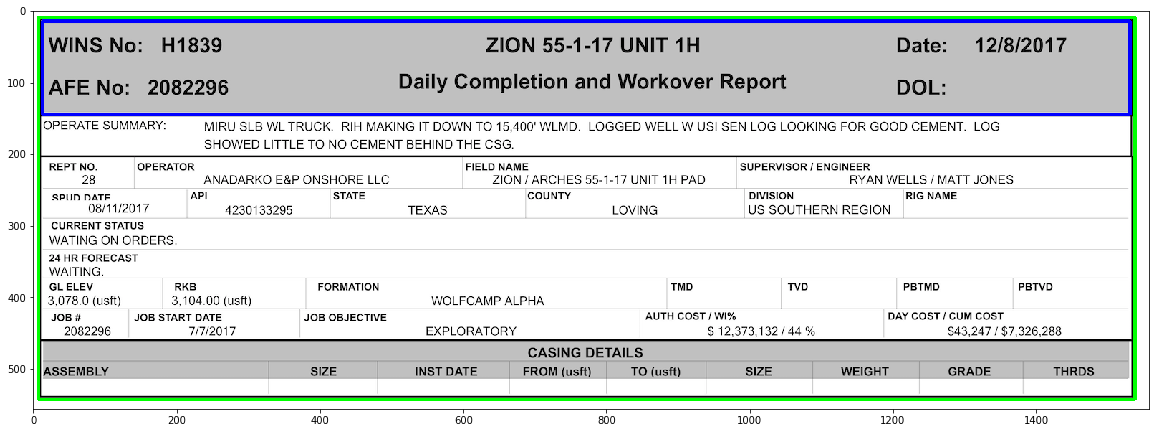

WINS No: H1839 ZION 55-1-17 UNIT 1H Date: 12/8/2017

AFE No: 2082296 Daily Completion and Workover Report DOL:


In [32]:
import sys, os
import cv2
import numpy as np
import pytesseract

import matplotlib.pyplot as plt

def test_get_header_text(file):
    table_image_contour = cv2.imread(file, 0)
    table_image = cv2.imread(file)
    ret, thresh_value = cv2.threshold(table_image_contour, 180, 255, cv2.THRESH_BINARY_INV)
    img_h = thresh_value.shape[0]
    img_w = thresh_value.shape[1]
    kernel = np.ones((5,5),np.uint8)
    dilated_value = cv2.dilate(thresh_value,kernel,iterations = 1)
    _, contours, hierarchy = cv2.findContours(dilated_value, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    t_x, t_y, t_w, t_h = cv2.boundingRect(max(contours, key=lambda cnt: cv2.contourArea(cnt)))
    table_image = cv2.rectangle(table_image, (t_x,t_y), (t_x+t_w,t_y+t_h), (0,255,0), 4)
    potential_headers = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
#        print("comparing: ", x, y, w, h)
        if (w > 0.9*t_w) and abs(t_y - y) < 50 and h < 0.3*t_h:
#            print("potential header ", x, y, w, h)
            potential_headers.append(cnt)
            table_image = cv2.rectangle(table_image, (x,y), (x+w,y+h), (255,0,0), 4)
    plt.figure(figsize=(20,10)) 
    plt.imshow(cv2.cvtColor(table_image, cv2.COLOR_BGR2RGB))
    plt.show()
    if len(potential_headers) > 0:
        header_cnt = min(potential_headers, key=lambda cnt: cv2.contourArea(cnt))
        x, y, w, h = cv2.boundingRect(header_cnt)
        header_img = table_image[y:y+h, x:x+w]
#        cv2.imshow('contour', table_image)
#        cv2.waitKey(0)
#        cv2.destroyAllWindows()    # Return the one with minumum area
        return pytesseract.image_to_string(header_img)
    print("no header")
    return ''

print(test_get_header_text('./data/test/2.png'))

open "./data/images/Cimarex/Affirmed 23 State Unit #2H Well History.pdf_0077.jpg"
text based
header text based
visual based
[ 7.75536415  1.14924435  1.16325026 ...  4.11150961  3.9378917
 11.93325173]


<Figure size 432x288 with 0 Axes>

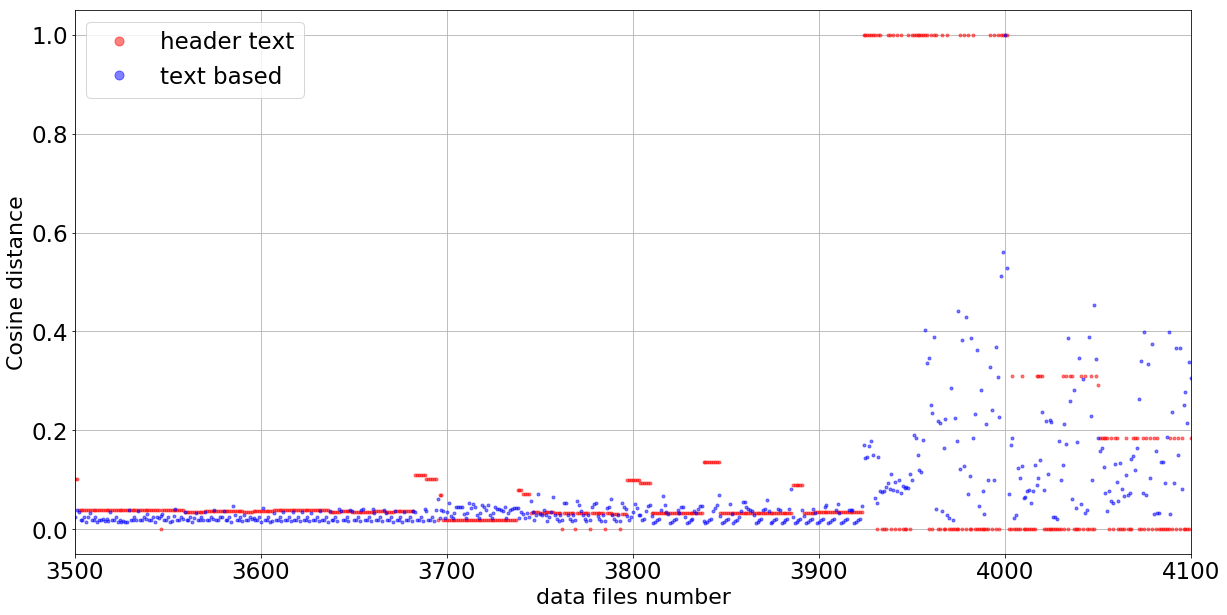

In [130]:
# test runs on July 11, 2020, Su
def test2_compare_text_vs_visual(input_dir, input_ds, feature_dir, feature_ds, idx_to_test):
    '''
    select result based on cosine similarity threshold. Let's set it to 0.95
    '''
    test_file_path = os.path.join(input_dir, input_ds.file_names[idx_to_test])
    logger.info('open \"{}\"'.format(test_file_path))

    contour_density, avg_color, text, header_text = get_precomputed_features(idx_to_test, input_ds)
    
    print('text based')
    result_text_indices, cosine_dist= text_based_match(feature_ds.vectorizer, feature_ds.matrix, text)
    thresh_06 = np.where(cosine_dist>0.6)
    print('header text based')
    if header_text != '':
        result_header, header_cosine_dist = header_text_based_match(feature_ds.header_vectorizer, feature_ds.header_matrix, header_text)
        # TODO: Add graphs
        
    print('visual based')
    result_visual_indices, euc_dist = contour_features_based_match(feature_ds.contour_features, [contour_density, avg_color])
    norm_euc = [float(i)/max(euc_dist) for i in euc_dist]
    print(euc_dist)
#     plt.figure(1)
#     plt.figure(figsize=(20,10)) 
#     plt.plot(norm_euc, '.r', alpha= 0.5, label = 'Normalized Euclidean')
#     plt.plot(cosine_dist, '.b', alpha= 0.5, label = 'Cosine')  
# #     plt.ylim([0,1])
#     plt.xlim([0,9000])
#     plt.legend(loc=1, fontsize=17, markerscale=3)
#     plt.grid()
#     plt.xlabel('data files number', fontsize =17)
#     plt.ylabel('distance (E/C)', fontsize =17)
#     plt.tick_params(labelsize=17)
#     plt.title('EOG', fontsize =17)
#     plt.savefig('./ppt_figs/EOG_distanceplot.png')
    # ---figure 2--
#     plt.figure(2)
#     plt.figure(figsize=(20,10)) 
#     plt.plot(euc_dist, '.r', alpha= 0.5, label = 'Euclidean distance')
#     plt.ylim([0,0.2])
#     plt.grid()
    
    # ---figure 3--
    plt.figure(1)
    plt.figure(figsize=(20,10)) 
    plt.plot(header_cosine_dist, '.r', alpha= 0.5, label = 'header text')
    plt.plot(cosine_dist, '.b', alpha= 0.5, label = 'text based')  
    plt.legend(loc=2, fontsize=23, markerscale=3)
    plt.xlabel('data files number', fontsize =22)
    plt.ylabel('Cosine distance', fontsize =22)
    plt.tick_params(labelsize=23)
    plt.xlim([3500, 4100])
#     plt.ylim([0,0.2])
    plt.grid()
    plt.savefig('./ppt_figs/Cimarex_distances_headertext.png')
    plt.show()

    
    return
#     for idx in range(5):
#         logger.info('open \"{}\"'.format(os.path.join(feature_dir, feature_ds.file_names[result_visual[idx]])))

    result = np.intersect1d(result_text, result_visual)
#     print('common: ' + str(len(result)))
#    for file_idx in result:
#        logger.info('open \"{}\"'.format(os.path.join(feature_dir, feature_ds.file_names[file_idx])))

#  2000(Anadarko), 4000(Cimarex), 7000(Devon), 8800 (EOG)
test_case_idx = 4000
test2_compare_text_vs_visual('./data/images/',
                            dataset,
                            './data/images/',
                            dataset,
                            test_case_idx)

In [17]:
# Testing NN on TF-IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import pandas as pd
import re

count = 100
train_text = [re.sub('[^a-zA-Z ]+', '', s.lower()) for s in dataset.documents]
target = [f.split('/')[0] for f in dataset.file_names]

test_text = train_text[1::2]
test_text = [s[0:50] for s in test_text]
test_target = target[1::2]

train_text = train_text[::2]
target = target[::2]

# Feature Engineering 
print ("TF-IDF on text data ... ")
tfidf = TfidfVectorizer(binary=True)
X = tfidf.fit_transform(train_text).astype('float16')
X_test = tfidf.transform(test_text).astype('float16')

# Label Encoding - Target 
print ("Label Encode the Target Variable ... ")
lb = LabelEncoder()
y = lb.fit_transform(target)
dummy_y_train = np_utils.to_categorical(y)

# Model Training 
print ("Create model ... ")
def build_model():
    model = Sequential()
    model.add(Dense(256, input_dim=30982, activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(Dense(200, activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(Dense(160, activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(Dense(120, activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(Dense(80, activation='relu'))
#     model.add(Dropout(0.3))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

print("Compile model ...")
estimator = KerasClassifier(build_fn=build_model, epochs=15, batch_size=128)
estimator.fit(X, dummy_y_train)

# Predictions 
print ("Predict on test data ... ")
y_test = estimator.predict(X_test)
y_pred = lb.inverse_transform(y_test)

match = 0
mismatch = 0
for i in range(len(y_pred)):
    if y_pred[i] == test_target[i]:
        match += 1
    else:
        mismatch +=1
print('match={}, mismatch={}'.format(match, mismatch))

TF-IDF on text data ... 
Label Encode the Target Variable ... 
Create model ... 
Compile model ...
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 256)               7931648   
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 1028      
Total params: 7,932,676
Trainable params: 7,932,676
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
36/36 [==============================] - 1s 17ms/step - loss: 0.6493 - accuracy: 0.9700
Epoch 2/15
36/36 [==============================] - 1s 20ms/step - loss: 0.0561 - accuracy: 0.9993
Epoch 3/15
36/36 [==============================] - 1s 16ms/step - loss: 0.0170 - accuracy: 0.9993
Epoch 4/15
36/36 [==============================] - 1s 17ms/step - loss: 0.0096 - accuracy: 0.9993
Epoch 5/15


In [132]:
def generate_node_input(ds, indexes, strategy, out_file_name, force_create=False):
    if os.path.exists(out_file_name) and not force_create:
        return pickle.load(open(out_file_name, "rb"))
    output = []
    for idx in tqdm(indexes):
        matches, distances = strategy(ds, idx)
        client = ds.file_names[idx].split('/')[0]
        for match in np.where(distances > 0.6)[0].tolist():
            output.append([idx, match, distances[match], client])

    os.makedirs((os.path.dirname(out_file_name)), exist_ok=True)
    pickle.dump(output, open(out_file_name, "wb"))
    return output

node_output = generate_node_input(dataset_100, range(len(dataset_100.file_names)),
                    text_based_match_for_index,
                    './data/simulation_results/node_input_text_100.pkl', True)

def print_idx(idxes):
    for idx in idxes:
        logger.info('open \"{}\"'.format(os.path.join('./data/images/', dataset_100.file_names[idx])))    

print_idx([4,8,23,32])

100%|██████████| 92/92 [00:00<00:00, 834.74it/s]

open "./data/images/Anadarko/Bull Run 1H Well Reports.pdf_0077.jpg"
open "./data/images/Anadarko/EBONY 55-1-40 UNIT 1H Completions.pdf_0028.jpg"
open "./data/images/Anadarko/PELICAN BAY 34-180 UNIT 1H Completion Rpts.pdf_0137.jpg"
open "./data/images/Anadarko/cc_SHILOH STATE 55-4-34 UNIT 1H Completion Rpts.pdf_0162.jpg"
